# Analysis of homogenized temperature data from the Netherlands

This notebook contains some Python code to analyze [homogenized monthly temperature data from KNMI's *De Bilt* weather station since 1901](http://projects.knmi.nl/klimatologie/onderzoeksgegevens/homogeen_260/tg_hom_mnd260.txt).

## Import prerequisites:

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from scipy.optimize import curve_fit

from bokeh.io       import show, output_notebook
from bokeh.layouts  import layout
from bokeh.models   import HoverTool, Range1d, ColumnDataSource, Whisker
from bokeh.palettes import d3
from bokeh.plotting import figure

output_notebook()

pd.set_option('display.max_columns', 40)

mycolors  = [d3['Category10'][10][i] for i in range(10)]
mycolors2 = [d3['Category20'][20][i] for i in range(20)]

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,scipy,matplotlib,bokeh
print("")
%watermark -m

/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading BokehJS ...

Author: gmalim

last updated: Mon Aug 13 2018

CPython 3.6.5
IPython 6.5.0

numpy 1.15.0
pandas 0.23.4
scipy 1.1.0
matplotlib 2.2.3
bokeh 0.13.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## Data processing

Load data:

In [2]:
df = pd.read_csv('tg_hom_mnd260.txt', names=['DATE', 'TGH'], skiprows=28, sep=' ', skipinitialspace=True)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df = df.reset_index()
df.drop(['index'], axis=1, inplace=True)

print(df.shape)
df.head()

(1411, 2)


DATE     TGH
0 1901-01-31  -0.424
1 1901-02-28  -0.761
2 1901-03-31   3.369
3 1901-04-30   8.782
4 1901-05-31  12.181

Select time period:

In [3]:
df = df.set_index('DATE')

start_year = 1901
end_year   = 2018

start_date = '{}-01-01'.format(start_year)
end_date   = '{}-12-31'.format(end_year)

df = df.loc[start_date:end_date]

df = df.reset_index()

print(df.shape)
df.head()

(1411, 2)


DATE     TGH
0 1901-01-31  -0.424
1 1901-02-28  -0.761
2 1901-03-31   3.369
3 1901-04-30   8.782
4 1901-05-31  12.181

In [4]:
display(df.describe().round(1))

TGH
count  1411.0
mean      9.4
std       5.6
min      -6.8
25%       4.7
50%       9.3
75%      14.5
max      22.2

Plot data:

In [5]:
tools = "pan,wheel_zoom,box_zoom,reset,hover,save"

fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI homogenized monthly temperature data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.y_range=Range1d(-10,25)

source_data = ColumnDataSource(data=df)

fig1.circle(x='DATE', y='TGH', source=source_data, 
            size=5, color=mycolors[0], muted_color=mycolors[0], alpha=0.5, muted_alpha=0.03)

hover = fig1.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Date",        "@DATE{%F}"   ),
                  ("Temperature", "@TGH{0.0 a}" )]
hover.formatters = {'DATE':'datetime'}

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

# Temperature distributions per month

Create month column in dataframe:

In [6]:
df['month'] = df['DATE'].dt.strftime('%m')
df['month'] = df['month'].astype('int64')

months = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 
          7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}

#for key in months.keys():    
#    df_tmp = df[(df['month'] == key)]
#    print(df_tmp.TGH.describe().round(1))

Create Gaussian function:

In [7]:
def mygaussian(x, ampl, mu, sigma):
    return ampl*np.exp(-(x-mu)**2/(2*sigma**2))

pg_min = ( 1, -10,  0.5)
pg_max = (50,  30, 10.0)
pg_bounds = (pg_min, pg_max)

Fit monthly temperature distributions with Gaussian functions:

Fitted Gaussian (January): 10.2*exp(-(x-2.8)^2/(2*2.2^2))
Fitted Gaussian (February): 10.4*exp(-(x-3.2)^2/(2*2.2^2))
Fitted Gaussian (March): 12.2*exp(-(x-5.2)^2/(2*2.0^2))
Fitted Gaussian (April): 17.3*exp(-(x-8.3)^2/(2*1.3^2))
Fitted Gaussian (May): 17.0*exp(-(x-12.7)^2/(2*1.4^2))
Fitted Gaussian (June): 18.0*exp(-(x-15.2)^2/(2*1.3^2))
Fitted Gaussian (July): 16.3*exp(-(x-16.8)^2/(2*1.4^2))
Fitted Gaussian (August): 18.0*exp(-(x-16.4)^2/(2*1.3^2))
Fitted Gaussian (September): 21.8*exp(-(x-13.9)^2/(2*1.0^2))
Fitted Gaussian (October): 16.5*exp(-(x-10.3)^2/(2*1.4^2))
Fitted Gaussian (November): 14.4*exp(-(x-6.0)^2/(2*1.6^2))
Fitted Gaussian (December): 12.7*exp(-(x-3.8)^2/(2*1.7^2))


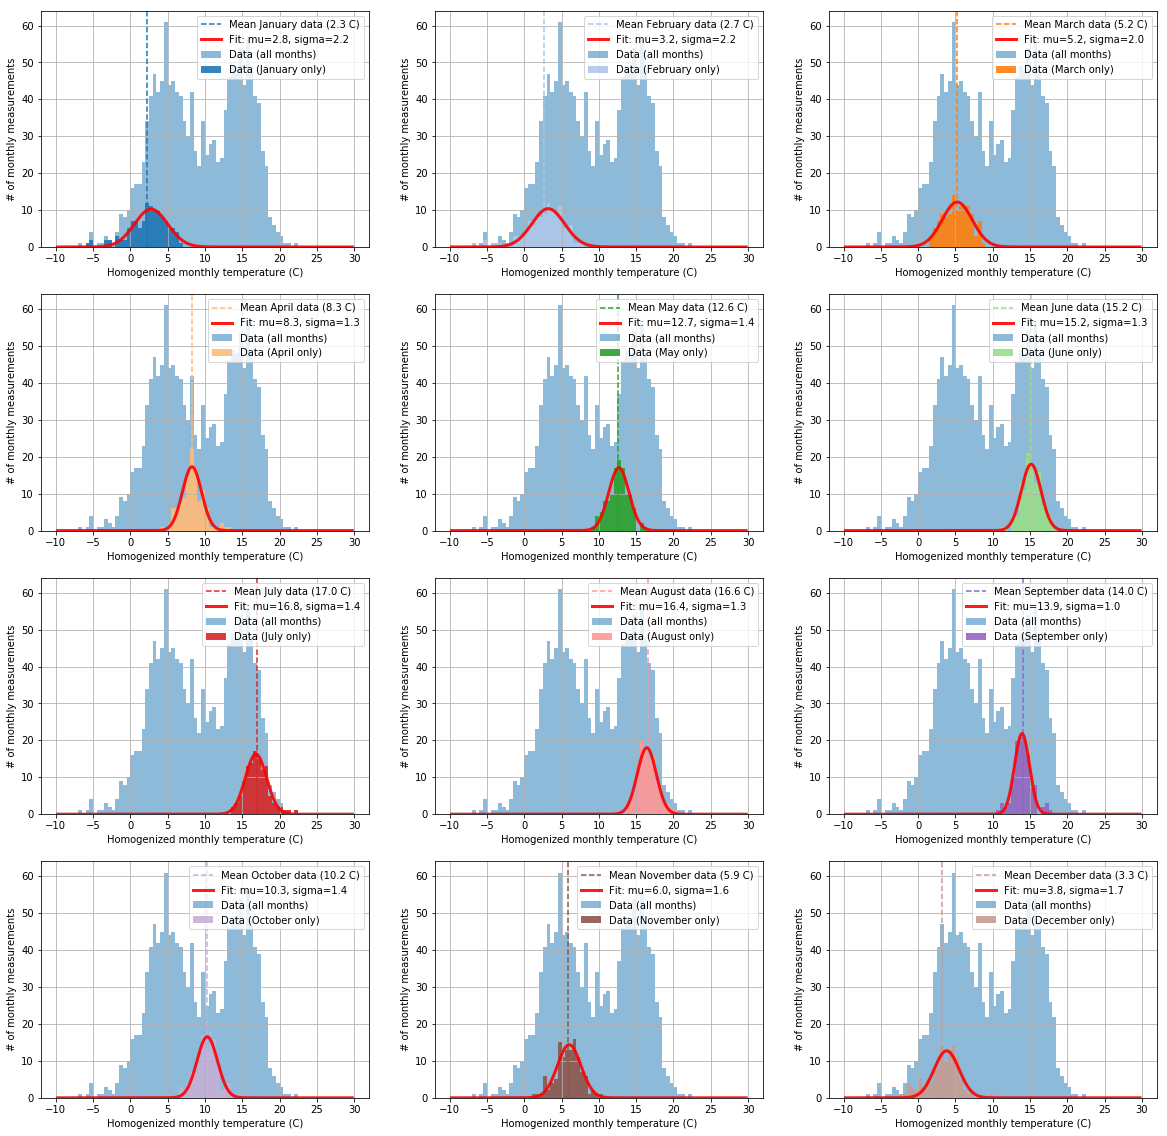

In [8]:
plt.figure(figsize=(20, 20))

n_data     = []
mu_data    = []
mu_fit     = []
sigma_data = []
sigma_fit  = []

for monthindex, month in months.items():

    plt.subplot(4, 3, monthindex)
    
    plt.hist(x=df.TGH, range=(-10,30), bins=80, alpha=0.5, color=mycolors[0], label='Data (all months)')
    
    df_tmp = df[(df['month'] == monthindex)]
    
    n_data.append(len(df_tmp))
    mu_data   .append(df_tmp.TGH.mean())
    sigma_data.append(df_tmp.TGH.std())
        
    bincontents_tmp, binedges_tmp, _ = plt.hist(x=df_tmp.TGH, range=(-10,30), bins=80,
                                                color=mycolors2[monthindex-1], alpha=0.9, 
                                                label='Data ({} only)'.format(month))
    
    bincentralvalues_tmp = [(binedges_tmp[i]+binedges_tmp[i+1])/2 for i in range(len(binedges_tmp)-1)]
    
    mean_tmp = df_tmp.TGH.mean()
    
    plt.axvline(x=mean_tmp, linestyle='--', color=mycolors2[monthindex-1], 
                label='Mean {} data ({:.1f} C)'.format(month, mean_tmp))
        
    x_data_tmp = bincentralvalues_tmp
    y_data_tmp = bincontents_tmp
    
    pg_start_tmp = [15, mean_tmp, 2]

    pg_opt_tmp, pg_cov_tmp = curve_fit(mygaussian, x_data_tmp, y_data_tmp, p0=pg_start_tmp, bounds=pg_bounds)

    mu_fit   .append(pg_opt_tmp[1])
    sigma_fit.append(pg_opt_tmp[2])
    
    label_g_tmp = "Fitted Gaussian ({}): {:.1f}*exp(-(x-{:.1f})^2/(2*{:.1f}^2))".format(month, *pg_opt_tmp)

    print(label_g_tmp)
    
    x_fit_tmp = np.linspace(min(x_data_tmp), max(x_data_tmp), num=len(x_data_tmp)*10)
    y_fit_tmp = mygaussian(x_fit_tmp, *pg_opt_tmp)

    plt.plot(x_fit_tmp, y_fit_tmp, lw=3, color='red', alpha=0.9,
             label="Fit: mu={:.1f}, sigma={:.1f}".format(pg_opt_tmp[1], pg_opt_tmp[2]))
    
    plt.legend(loc='upper right')
    plt.ylabel('# of monthly measurements')
    plt.xlabel('Homogenized monthly temperature (C)')
    plt.grid(True)

Create sine function:

In [9]:
def myfunc1(x, ampl, hoffset, voffset):
    return  ampl*np.sin(2*np.pi*(x - hoffset)/12) + voffset

p1_start = [1, 0, 0]
p1_min = (     0,  0, -np.inf)
p1_max = (np.inf, 12,  np.inf)
p1_bounds = (p1_min, p1_max)

Fit mean monthly temperature distribution with sine function:

In [10]:
x_data = range(1,13)
#y_data = mu_data
y_data = mu_fit

#y_data_sigma = sigma_data/np.sqrt(df.shape[0]/12) # sigma_mean = sigma/sqrt(N) 
y_data_sigma = sigma_fit /np.sqrt(df.shape[0]/12) # sigma_mean = sigma/sqrt(N)

p1_opt, p1_cov = curve_fit(myfunc1, x_data, y_data, p0=p1_start, bounds=p1_bounds,
                           sigma=y_data_sigma, absolute_sigma=True)

print("Fitted sine function: f(t) = ampl*sin(2π(t - hoffset)/12) + voffset")
print("")
print("--> Fitted parameters [ampl, hoffset, voffset]:")
print(p1_opt.round(3))
print("--> Covariance matrix:")
print(p1_cov)
p1_err = np.sqrt(np.diag(p1_cov))
print("--> Fitted parameter standard deviations:")
print(p1_err.round(3))
y_fit = myfunc1(x_data, *p1_opt)
residual = y_data - y_fit
chisq = np.sum((residual/y_data_sigma)**2)
ndata = len(x_data)
npfit = len(p1_opt)
print('--> chisq/ndf = {:.2f}/({:.2g}-{:.2g}) = {:.2f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

Fitted sine function: f(t) = ampl*sin(2π(t - hoffset)/12) + voffset

--> Fitted parameters [ampl, hoffset, voffset]:
[7.312 4.224 9.511]
--> Covariance matrix:
[[ 3.73842816e-03 -1.98768284e-05 -8.61782313e-04]
 [-1.98768284e-05  1.83551372e-04 -4.26062760e-05]
 [-8.61782313e-04 -4.26062760e-05  1.68334686e-03]]
--> Fitted parameter standard deviations:
[0.061 0.014 0.041]
--> chisq/ndf = 52.22/(12-3) = 5.80


Plot mean monthly temperatures & fitted sine function, and the monthly temperature range (mean_data +/- 1 sigma_data):

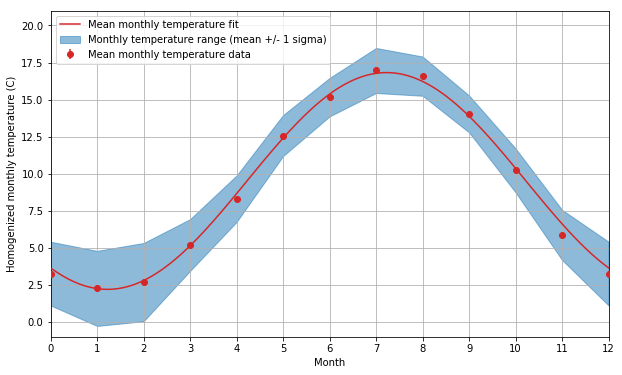

In [11]:
plt.figure(figsize=(10,6))

monthindices = range(0,13)

mus_tmp = [mu_data[-1]]
for i in mu_data:
    mus_tmp.append(i)

sigmas_tmp = [sigma_data[-1]]
for i in sigma_data:
    sigmas_tmp.append(i)

min_temp = np.subtract(mus_tmp, sigmas_tmp)
max_temp = np.add     (mus_tmp, sigmas_tmp)

mu_stdev = np.array(sigmas_tmp)
mu_stdev = mu_stdev/np.sqrt(df.shape[0]/12)

plt.fill_between(monthindices, min_temp, max_temp, color=mycolors[0], alpha=0.5, 
                 label='Monthly temperature range (mean +/- 1 sigma)')
plt.errorbar(monthindices, mus_tmp, yerr=mu_stdev, color=mycolors[3], fmt='o', zorder=10, 
             label='Mean monthly temperature data')

x_fit = np.linspace(0, 12, num=100)
y_fit = myfunc1(x_fit, *p1_opt)

plt.plot(x_fit, y_fit, color=mycolors[3], label='Mean monthly temperature fit', zorder=10)

plt.legend(loc='upper left')
plt.xticks(monthindices)
plt.xlabel('Month')
plt.ylabel('Homogenized monthly temperature (C)')
plt.xlim(0, 12)
plt.ylim(-1, 21)
plt.grid(True)

# Temperature-time distribution

Create quantities needed to fit temperature-time distribution:

In [12]:
x_data = df.index
y_data = df.TGH

y_data_sigma = []

for i in range(0, len(x_data)):
    month_i = df.month[i]
    sigma_i = sigma_fit[month_i-1]
    y_data_sigma.append(sigma_i)

Create functions to fit temperature-time distribution:

In [13]:
def myfunc2(x, slope, voffset): # 1st order polynomial function
    return slope*x + voffset

p2_start = [0, 0]
p2_min = (-np.inf, -np.inf)
p2_max = ( np.inf,  np.inf)
p2_bounds = (p2_min, p2_max)

In [14]:
def myfunc3(x, ampl, hoffset, slope, voffset): # sine + 1st order polynomial function
    return ampl*np.sin(2*np.pi*(x - hoffset)/12) + slope*x + voffset

p3_start = [1, 0, 0, 0]
p3_min = (     0,  0, -np.inf, -np.inf)
p3_max = (np.inf, 12,  np.inf,  np.inf)
p3_bounds = (p3_min, p3_max)

Fit temperature-time distribution:

In [15]:
p1_opt, p1_cov = curve_fit(myfunc1, x_data, y_data, p0=p1_start, bounds=p1_bounds,
                           sigma=y_data_sigma, absolute_sigma=True)

print("Fitted sine function: f(t) = ampl*sin(2π(t - hoffset)/12) + voffset")
print("")
print("--> Fitted parameters [ampl, hoffset, voffset]:")
print(p1_opt)
print("--> Covariance matrix:")
print(p1_cov)
p1_err = np.sqrt(np.diag(p1_cov))
print("--> Fitted parameter standard deviations:")
print(p1_err)
y_fit = myfunc1(x_data, *p1_opt)
residual = y_data - y_fit
chisq = np.sum((residual/y_data_sigma)**2)
ndata = len(x_data)
npfit = len(p1_opt)
print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

label1 = "Fitted sine: {:.2f}*sin(2π(t - {:.2f})/12) + {:.2f}".format(*p1_opt)

Fitted sine function: f(t) = ampl*sin(2π(t - hoffset)/12) + voffset

--> Fitted parameters [ampl, hoffset, voffset]:
[7.59354261 3.22054494 9.39584924]
--> Covariance matrix:
[[ 3.73900391e-03 -1.89301604e-05 -8.61181179e-04]
 [-1.89301604e-05  1.70256125e-04 -3.94049552e-05]
 [-8.61181179e-04 -3.94049552e-05  1.68322375e-03]]
--> Fitted parameter standard deviations:
[0.06114739 0.01304822 0.04102711]
--> chisq/ndf = 1751.400695/(1411-3) = 1.243893


In [16]:
p2_opt, p2_cov = curve_fit(myfunc2, x_data, y_data, p0=p2_start, bounds=p2_bounds,
                           sigma=y_data_sigma, absolute_sigma=True)

print("Fitted 1st order polynomial function: f(t) = slope*t + voffset")
print("")
print("--> Fitted parameters [slope, voffset]:")
print(p2_opt)
print("--> Covariance matrix:")
print(p2_cov)
p2_err = np.sqrt(np.diag(p2_cov))
print("--> Fitted parameter standard deviations:")
print(p2_err)
y_fit = myfunc2(x_data, *p2_opt)
residual = y_data - y_fit
chisq = np.sum((residual/y_data_sigma)**2)
ndata = len(x_data)
npfit = len(p2_opt)
print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

label2 = "Fitted pol1: {:.4f}*t + {:.2f}".format(*p2_opt)

Fitted 1st order polynomial function: f(t) = slope*t + voffset

--> Fitted parameters [slope, voffset]:
[1.22802138e-03 1.02887796e+01]
--> Covariance matrix:
[[ 8.89491136e-09 -6.27218278e-06]
 [-6.27218278e-06  5.89640160e-03]]
--> Fitted parameter standard deviations:
[9.43128377e-05 7.67880303e-02]
--> chisq/ndf = 17012.272407/(1411-2) = 12.074005


In [17]:
p3_opt, p3_cov = curve_fit(myfunc3, x_data, y_data, p0=p3_start, bounds=p3_bounds,
                           sigma=y_data_sigma, absolute_sigma=True)

print("Fitted sine + 1st order polynomial function: f(t) = ampl*sin(2π(t - hoffset)/12) + slope*t + voffset")
print("")
print("--> Fitted parameters [ampl, hoffset, slope, voffset]:")
print(p3_opt)
print("--> Covariance matrix:")
print(p3_cov)
p3_err = np.sqrt(np.diag(p3_cov))
print("--> Fitted parameter standard deviations:")
print(p3_err)
y_fit = myfunc3(x_data, *p3_opt)
residual = y_data - y_fit
chisq = np.sum((residual/y_data_sigma)**2)
ndata = len(x_data)
npfit = len(p3_opt)
print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

label3 = "Fitted sine + pol1: {:.2f}*sin(2π(t - {:.2f})/12) + {:.4f}*t + {:.2f}".format(*p3_opt)

Fitted sine + 1st order polynomial function: f(t) = ampl*sin(2π(t - hoffset)/12) + slope*t + voffset

--> Fitted parameters [ampl, hoffset, slope, voffset]:
[7.59292157e+00 3.22070494e+00 1.21907859e-03 8.53632745e+00]
--> Covariance matrix:
[[ 3.73899359e-03 -1.89543469e-05 -4.53115252e-09 -8.57999582e-04]
 [-1.89543469e-05  1.70284921e-04  1.16744214e-09 -4.02131442e-05]
 [-4.53115252e-09  1.16744214e-09  8.89492458e-09 -6.27144266e-06]
 [-8.57999582e-04 -4.02131442e-05 -6.27144266e-06  6.10495804e-03]]
--> Fitted parameter standard deviations:
[6.11473106e-02 1.30493264e-02 9.43129078e-05 7.81342309e-02]
--> chisq/ndf = 1584.321976/(1411-4) = 1.126028


Create fitted functions:

In [18]:
x_fit = np.linspace(x_data.min(), x_data.max(), num=len(x_data)*10)

y_fit1 = myfunc1(x_fit, *p1_opt)
y_fit2 = myfunc2(x_fit, *p2_opt)
y_fit3 = myfunc3(x_fit, *p3_opt)

Plot temperature-time distribution and fitted functions:

In [19]:
tools = "pan,wheel_zoom,box_zoom,reset,hover,save"

fig1 = figure(plot_width=900, plot_height=450, tools=tools, toolbar_location='above')
fig1.title.text = "Homogenized monthly temperatures {}-{}, KNMI weather station De Bilt".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Time (months since Jan 1901)"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.y_range=Range1d(-10,25)

source_error = ColumnDataSource(data=dict(base=x_data, lower=(y_data-y_data_sigma), upper=(y_data+y_data_sigma)))

w = Whisker(source=source_error, base="base", upper="upper", lower="lower", line_color=mycolors[0], line_alpha=0.5)
#w.upper_head.line_color = mycolors[2]
#w.lower_head.line_color = mycolors[2]
#w.upper_head.line_alpha = 0.5
#w.lower_head.line_alpha = 0.5
w.upper_head = None
w.lower_head = None

fig1.add_layout(w)

fig1.circle(x='index', y='TGH', source=source_data, size=5, color=mycolors[0], alpha=0.7)

fig1.line(x=x_fit, y=y_fit1, legend=label1,
          line_width=3, color=mycolors[2], muted_color=mycolors[2], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit2, legend=label2,
          line_width=3, color=mycolors[1], muted_color=mycolors[1], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit3, legend=label3,
          line_width=3, color=mycolors[3], muted_color=mycolors[3], alpha=0.7, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'hide'

hover = fig1.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Date",        "@DATE{%F}"   ),
                  ("Temperature", "@TGH{0.0 a}" )]
hover.formatters = {'DATE':'datetime'}

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

# Temperature-time distributions per month

Create quantities needed to fit temperature-time distributions for each month separately:

In [20]:
df_months           = []
x_data_months       = []
y_data_months       = []
y_data_sigma_months = []

for monthindex, month in months.items():

    df_tmp = df[(df['month'] == monthindex)]
    df_tmp['fullindex'] = df_tmp.index
    df_tmp = df_tmp.reset_index()

    x_data_tmp = df_tmp.fullindex
    y_data_tmp = df_tmp.TGH

    y_data_sigma_tmp = []

    for i in range(len(x_data_tmp)):
        month_i = df_tmp.month[i]
        sigma_i = sigma_fit[month_i-1]
        y_data_sigma_tmp.append(sigma_i)
        
    df_months.append(df_tmp)
    x_data_months.append(x_data_tmp)
    y_data_months.append(y_data_tmp)
    y_data_sigma_months.append(y_data_sigma_tmp)

/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Fit monthly temperature-time distributions:

In [21]:
p_opt_months = []
p_err_months = []
rchi2_months = []

for monthindex, month in months.items():
    
    x_data_tmp       = x_data_months      [monthindex-1]
    y_data_tmp       = y_data_months      [monthindex-1]
    y_data_sigma_tmp = y_data_sigma_months[monthindex-1]
    
    p_opt_tmp, p_cov_tmp = curve_fit(myfunc2, x_data_tmp, y_data_tmp, p0=p2_start, bounds=p2_bounds, 
                                     sigma=y_data_sigma_tmp, absolute_sigma=True)

    print("{:-^72s}".format(" {} ".format(month)))
    print("")
    print("Fitted 1st order polynomial function: f(t) = slope*t + voffset")
    print("")
    print("--> Fitted parameters [slope, voffset]:")
    print(p_opt_tmp)
    print("--> Covariance matrix:")
    print(p_cov_tmp)
    p_err_tmp = np.sqrt(np.diag(p_cov_tmp))
    print("--> Fitted parameter standard deviations:")
    print(p_err_tmp)
    y_fit_tmp = myfunc2(x_data_tmp, *p_opt_tmp)
    residual_tmp = y_data_tmp - y_fit_tmp
    chisq_tmp = np.sum((residual_tmp/y_data_sigma_tmp)**2)
    ndata_tmp = len(x_data_tmp)
    npfit_tmp = len(p_opt_tmp)
    rchi2_tmp = chisq_tmp/(ndata_tmp - npfit_tmp)
    print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq_tmp, ndata_tmp, npfit_tmp, rchi2_tmp))
    print("")
    
    p_opt_months.append(p_opt_tmp)
    p_err_months.append(p_err_tmp)
    rchi2_months.append(rchi2_tmp)

------------------------------- January --------------------------------

Fitted 1st order polynomial function: f(t) = slope*t + voffset

--> Fitted parameters [slope, voffset]:
[1.28340625e-03 1.36372677e+00]
--> Covariance matrix:
[[ 2.53285227e-07 -1.77806229e-04]
 [-1.77806229e-04  1.67137855e-01]]
--> Fitted parameter standard deviations:
[0.00050327 0.40882497]
--> chisq/ndf = 143.749800/(118-2) = 1.239222

------------------------------- February -------------------------------

Fitted 1st order polynomial function: f(t) = slope*t + voffset

--> Fitted parameters [slope, voffset]:
[7.38619569e-04 2.16828434e+00]
--> Covariance matrix:
[[ 2.44901453e-07 -1.72165722e-04]
 [-1.72165722e-04  1.61949659e-01]]
--> Fitted parameter standard deviations:
[0.00049488 0.40242969]
--> chisq/ndf = 166.638686/(118-2) = 1.436540

-------------------------------- March ---------------------------------

Fitted 1st order polynomial function: f(t) = slope*t + voffset

--> Fitted parameters [slope

Create fitted monthly temperature-time distributions:

In [22]:
y_fit_months = []

for monthindex, month in months.items():

    y_fit_tmp = myfunc2(x_fit, *p_opt_months[monthindex-1])
    y_fit_months.append(y_fit_tmp)

Plot monthly temperature-time distributions and fitted functions:

In [23]:
tools = "pan,wheel_zoom,box_zoom,reset,save"

fig1 = figure(plot_width=900, plot_height=450, tools=tools, toolbar_location='above')
fig1.title.text = "Homogenized monthly temperatures {}-{}, KNMI weather station De Bilt".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Time (months since January 1901)"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.x_range=Range1d(-50,1700)
fig1.y_range=Range1d(-10,25)

w = Whisker(source=source_error, base="base", upper="upper", lower="lower", line_color='grey', line_alpha=0.1)
#w.upper_head.line_color = 'grey'
#w.lower_head.line_color = 'grey'
#w.upper_head.line_alpha = 0.5
#w.lower_head.line_alpha = 0.5
w.upper_head = None
w.lower_head = None
fig1.add_layout(w)

fig1.circle(x='index', y='TGH', source=source_data, size=5, color='grey', alpha=0.1)

for monthindex, month in months.items():
    
    df_tmp = df_months[monthindex-1]
    
    fig1.circle(x=df_tmp.fullindex, y=df_tmp.TGH, legend=month,
                color=mycolors2[monthindex-1], size=5, alpha=0.5)

    fig1.segment(x0=df_tmp.fullindex, y0=(df_tmp.TGH - y_data_sigma[monthindex-1]), 
                 x1=df_tmp.fullindex, y1=(df_tmp.TGH + y_data_sigma[monthindex-1]),
                 line_color=mycolors2[monthindex-1], line_alpha=0.5, legend=month)
    
    fig1.line(x=x_fit, y=y_fit_months[monthindex-1], legend=month,
              color=mycolors2[monthindex-1], line_width=3, alpha=1)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'hide'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

Summarize fit results of monthly temperature-time distributions:

In [24]:
fitresults = []

for monthindex, month in months.items():
    
    fitresults.append({'month'         : month, 
                       'n'             : n_data[monthindex-1],
                       'slope'         : p_opt_months[monthindex-1][0],
                       'slope_sigma'   : p_err_months[monthindex-1][0], 
                       'voffset'       : p_opt_months[monthindex-1][1],
                       'voffset_sigma' : p_err_months[monthindex-1][1], 
                       'rchi2'         : rchi2_months[monthindex-1]})    
    
columnorder = ['month', 'n', 'slope', 'slope_sigma', 'voffset', 'voffset_sigma', 'rchi2']

#pd.set_option('precision', 2)
pd.set_option('display.float_format', '{:06.5f}'.format)
df_fitresults = pd.DataFrame(fitresults, columns=columnorder)
df_fitresults.index += 1
display(df_fitresults)

month    n   slope  slope_sigma  voffset  voffset_sigma   rchi2
1     January  118 0.00128      0.00050  1.36373        0.40882 1.23922
2    February  118 0.00074      0.00049  2.16828        0.40243 1.43654
3       March  118 0.00129      0.00045  4.28297        0.36842 0.69018
4       April  118 0.00164      0.00029  7.15567        0.23555 1.22713
5         May  118 0.00085      0.00031 11.97433        0.25031 0.97252
6        June  118 0.00116      0.00029 14.34596        0.24057 0.85763
7        July  118 0.00155      0.00032 15.86737        0.26248 0.94388
8      August  117 0.00158      0.00029 15.47377        0.23642 0.83028
9   September  117 0.00090      0.00023 13.39906        0.18561 1.42304
10    October  117 0.00101      0.00031  9.51424        0.25417 1.08955
11   November  117 0.00161      0.00036  4.73838        0.29425 0.97815
12   December  117 0.00107      0.00038  2.50539        0.31094 1.59686

## Conclusion

Calculate temperature-over-time gradients and corresponding gradient errors from fits:

In [25]:
'''
# If sample sizes for all months are equal:

mean_slope = df_fitresults.slope.mean()
mean_sigma = np.sqrt((df_fitresults.slope_sigma**2).mean())
'''

# If sample sizes for all months are not equal:

mean_slope       = 0
mean_sigmaslope  = 0
for i in df_fitresults.index:
    mean_slope      += df_fitresults.n[i]*df_fitresults.slope[i]
    mean_sigmaslope += (df_fitresults.n[i] - 1)*df_fitresults.slope_sigma[i]**2
mean_slope      = mean_slope/sum(df_fitresults.n)
mean_sigmaslope = np.sqrt(mean_sigmaslope/(sum(df_fitresults.n) - 12))

print("--> Mean slope +/- 1 sigma of monthly pol1 fits = {:.2f} +/- {:.2f} degrees Celsius per century"\
      .format(mean_slope*1200, mean_sigmaslope*1200))

--> Mean slope +/- 1 sigma of monthly pol1 fits = 1.47 +/- 0.44 degrees Celsius per century


In [26]:
print("--> Slope +/- 1 sigma of full sine + pol1 fit = {:.2f} +/- {:.2f} degrees Celsius per century"\
      .format(p3_opt[2]*1200, p3_err[2]*1200))

--> Slope +/- 1 sigma of full sine + pol1 fit = 1.46 +/- 0.11 degrees Celsius per century
